In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io as sio

from utils import *
from Network import *

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
data = sio.matlab.loadmat('../data/FlatBeam_NLResponse_RandVibe.mat')['out']
y = data[0]['def'][0].T[:, :, np.newaxis][:,10,:]
yv = data[0]['vel'][0].T[:, :, np.newaxis][:,10,:]
ya = data[0]['acc'][0].T[:, :, np.newaxis][:,10,:]
u = data[0]['fext'][0].T[:, :, np.newaxis][:,10,:]
t = data[0]['t'][0][0]

print(y.shape, u.shape, t.shape)

(10001, 1) (10001, 1) (10001,)


In [3]:
umax = np.max(u)
ymax = np.max(np.abs([y,yv,ya]), axis = 1)
print(ymax)

u_norm = u/umax
y_norm = y/ymax[0]
yv_norm = yv/ymax[1]
ya_norm = ya/ymax[2]

N = len(u)
ntrain = int(N*0.5)
start = 50

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
yvtrain = yv_norm[start:ntrain]
yatrain = ya_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain,yvtrain,yatrain])
outtrain = np.hstack([ytrain,yvtrain,yatrain])

utest = u_norm[ntrain:start+ntrain+500]
ytest = y_norm[ntrain:start+ntrain+500]
yvtest = yv_norm[ntrain:start+ntrain+500]
yatest = ya_norm[ntrain:start+ntrain+500]
ttest = t[ntrain:start+ntrain+500]
intest = np.hstack([utest,ytest,yvtest,yatest])
outtest = np.hstack([ytest,yvtest,yatest])

ufull = np.concatenate([utrain, utest], axis = 0)
yfull = np.concatenate([ytrain, ytest], axis = 0)
infull = np.concatenate([intrain, intest], axis = 0)
outfull = np.concatenate([outtrain, outtest], axis = 0)

[[3.31365126e-02]
 [5.66465450e+01]
 [2.02096860e+05]]
5000


In [4]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xya = input_data[i:(i+tw), 3]
        xyv = input_data[i:(i+tw), 2]
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy,xyv,xya])
        y = output_data[i+tw,:]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [5]:
train_window = 24

x_train, y_train = create_inout_sequences(intrain, outtrain, train_window)
x_val, y_val = create_inout_sequences(intest, outtest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

x_full, y_full = create_inout_sequences(infull, outfull, train_window)

x_full = torch.from_numpy(x_full).float()
y_full = torch.from_numpy(y_full).float()

print(x_full.shape, y_full.shape)

torch.Size([4925, 4, 24]) torch.Size([4925, 3])
torch.Size([5475, 4, 24]) torch.Size([5475, 3])


In [6]:
#hyperparams
input_size = 3
enc_seq_len = train_window
dec_seq_len = 4
output_sequence_length = 1

dim_val = 10
dim_attn = 5
lr = 0.002
epoch = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 15

#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

In [ ]:
X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
X.size()

In [ ]:
def train(model, epoch, X_train, Y_train, batch_size):
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        output = model(x)
        print(output.size())
        
        break
        
train(t, epoch, x_train, y_train, batch_size)

In [5]:
for e in range(epochs):
    out = []
    
    for b in range(-10- enc_seq_len, 10 - enc_seq_len):
        optimizer.zero_grad()
        X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - Y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss)
        print(loss)

tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)


<IPython.core.display.Javascript object>


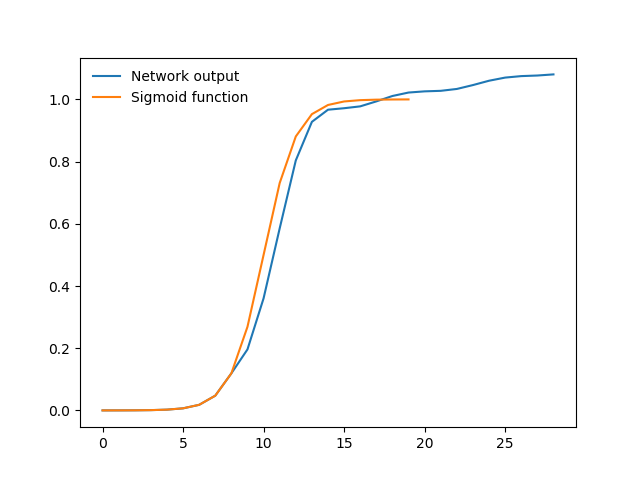

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

o = []
x = [torch.sigmoid(torch.arange(-10,-1).float()).unsqueeze(-1).numpy().tolist()]

#Draw graph comparing to sigmoid
for i in range(-10, 10, output_sequence_length):
    o.append([torch.sigmoid(torch.tensor(i).float())])
    q = torch.tensor(x).float()
    
    if(output_sequence_length == 1):
        x[0].append([t(q).detach().squeeze().numpy()])
    else:
        for a in t(q).detach().squeeze().numpy():
            x[0].append([a])
            
ax.clear()
ax.plot(x[0], label='Network output')
ax.plot(o, label='Sigmoid function')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)